In [ ]:
!pip install torch_optimizer

In [ ]:
import numpy as np
import torch
from torchvision import datasets, transforms
from torch.utils.data.sampler import SubsetRandomSampler
import matplotlib.pyplot as plt
import pandas as pd
from torchsummary import summary
import torch_optimizer as optim

In [ ]:
# Function for data augmentation for train and test dataset
def get_transformations():
    train_transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.RandomCrop(32, padding=6), # Randomly crops the image and resizes it. If the crop image size is same as the image, it randomizes the image patches
        transforms.RandomHorizontalFlip(), # Horizontally flips the image with the probability of 50%
        transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1), # increases brightness, contrast, sturation and hue of the image
        transforms.RandomRotation(20), # Randomly rotates the image with degree 20
        transforms.RandomAffine(degrees=10, translate=(0.2, 0.2)), # Applies random affine
        transforms.ToTensor(), # Converts the image to tensors, also scales it from 0-1
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), # Normalize
    ])

    test_transform = transforms.Compose([
        # transforms.ToPILImage(),
        transforms.ToTensor(), # Converts the image to tensors, scales it from 0-1
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2470, 0.2435, 0.2616)), # Normalize
    ])

    return train_transform, test_transform

In [ ]:
# Dataset
train_transform, test_transform = get_transformations()
train = datasets.CIFAR10('./data', train=True, download=True, transform=train_transform)
test = datasets.CIFAR10('./data', train=False, download=True, transform=test_transform)
# Data Loader
train_data_loader  = torch.utils.data.DataLoader(train, batch_size=128,shuffle=True)
validation_data_loader  = torch.utils.data.DataLoader(test, batch_size=128,shuffle=False)

100%|██████████| 170M/170M [00:15<00:00, 10.9MB/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [ ]:
# ResNet Model

# Squeeze and excitation block
class SE_Block(torch.nn.Module):
    def __init__(self, channels, reduction=16):
        super(SE_Block, self).__init__()
        # Adaptive Average Pooling:
        # This reduces the spatial dimensions (H x W) to 1x1, effectively summarizing
        # the feature maps across spatial dimensions into a single value per channel.
        self.avg_pool = torch.nn.AdaptiveAvgPool2d(1)

        # Fully connected layers for recalibrating channel importance
        self.fc = torch.nn.Sequential(
            torch.nn.Linear(channels, channels // reduction, bias=False),  # Reduction step: Compress the channel dimension
            torch.nn.ReLU(inplace=True),  # Non-linearity to introduce non-linear transformations
            torch.nn.Linear(channels // reduction, channels, bias=False),  # Restore the channel dimension
            torch.nn.Sigmoid()  # Outputs attention weights in the range [0,1] to reweight feature maps
        )
    def forward(self, x):
        batch, channels, w, h = x.size() # Extract batch size, channel, width, and height

        # Squeeze step: Apply global average pooling and reshape to (batch, channels)
        y = self.avg_pool(x).view(batch, channels)

        # Excitation step: Pass through the fully connected layers to learn channel importance
        y = self.fc(y).view(batch, channels, 1, 1) # Reshape to (batch, channels, 1, 1) for broadcasting

        # Scale the original input feature maps by learned channel-wise weights
        return x * y.expand_as(x)# Broadcasting ensures each channel is multiplied by its learned weight

class ResNet_Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None, use_se_block=False):
        super(ResNet_Block, self).__init__()

        # Architechture (Basic)
        # CONV -> BN -> ReLU -> CONV -> BN -> Addition -> ReLU
        # Architechture (With SE)
        # CONV -> BN -> ReLU -> CONV -> BN -> SE Block -> Addition -> ReLU

        # First convolutional layer:
        # - Uses a 3x3 kernel with possible downsampling (stride != 1 for size reduction)
        # - Applies Batch Normalization to stabilize training
        # - Uses ReLU activation for non-linearity
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 3, stride = stride, padding=1),
                                torch.nn.BatchNorm2d(out_channels),
                                torch.nn.ReLU())
        # Second convolutional layer:
        # - Uses a 3x3 kernel with a fixed stride of 1 (no downsampling here)
        # - Applies Batch Normalization
        # - No activation function applied before the skip connection addition
        self.convolution2 = torch.nn.Sequential(
                                torch.nn.Conv2d(out_channels, out_channels, kernel_size = 3, stride = 1, padding = 1), 
                                torch.nn.BatchNorm2d(out_channels))
        # Downsampling layer:
        # - Used when the input and output dimensions differ (e.g., due to stride > 1)
        # - Ensures the skip connection can match the new feature map dimensions
        self.downsample = downsample
        self.relu = torch.nn.ReLU()
        # Option to use a Squeeze-and-Excitation (SE) block
        self.use_se_block = use_se_block
        self.se_block = SE_Block(out_channels)


    def forward(self, x):
        res = x # Residual
        if self.downsample is not None: # If downsampling
            res = self.downsample(x) # The input is downsampled

        out = self.convolution1(x) # Conv1
        out = self.convolution2(out) # Conv2

        #SE Block
        if self.use_se_block:
          out = self.se_block(out)

        z = out + res # Identity mapping
        z = self.relu(z) # Final ReLU

        return z


class PreActivation_ResNet_Block(torch.nn.Module):
    def __init__(self, in_channels, out_channels, stride = 1, downsample = None, use_se_block=False):
        super(PreActivation_ResNet_Block, self).__init__()

        # Architechture (Basic)
        # BN -> ReLU -> CONV ->  BN -> ReLU -> CONV -> Addition
        # Architechture (With SE)
        # BN -> ReLU -> CONV ->  BN -> ReLU -> CONV -> SE Block -> Addition

        # Batch Normalization
        self.bn1 = torch.nn.BatchNorm2d(in_channels)

        # ReLU
        self.relu1 = torch.nn.ReLU(inplace=True)

        #Uses a 3x3 kernel with possible downsampling (stride != 1 for size reduction)
        self.conv1 = torch.nn.Conv2d(in_channels, out_channels, kernel_size=3, stride=stride, padding=1, bias=False)

        # Batch Normalization
        self.bn2 = torch.nn.BatchNorm2d(out_channels)

        # ReLU
        self.relu2 = torch.nn.ReLU(inplace=True)

        #Uses a 3x3 kernel with a fixed stride of 1 (no downsampling here)
        self.conv2 = torch.nn.Conv2d(out_channels, out_channels, kernel_size=3, stride=1, padding=1, bias=False)
        self.downsample = downsample
        self.use_se_block = use_se_block
        self.se_block = SE_Block(out_channels)

    def forward(self, x):
        residual = x
        out = self.bn1(x)
        out = self.relu1(out)
        # Because of preactivation dowsampling is done after BN -> ReLU's output and not on the input directly
        if self.downsample is not None:
            residual = self.downsample(out)

        out = self.conv1(out)

        out = self.bn2(out)
        out = self.relu2(out)
        out = self.conv2(out)

        if self.use_se_block:
          out = self.se_block(out)

        out += residual
        return out

class ResNet(torch.nn.Module):
    def __init__(self, block, layers):
        super(ResNet, self).__init__()
        self.block = block
        # Input = 3 channels, 32 * 32
        # Initial Convolution that uses a 5 * 5 kernel with stride = 1 and padding = 2.
        # Creates 64 channels
        # Batch Normalization
        # ReLU
        self.convolution1 = torch.nn.Sequential(
                                torch.nn.Conv2d(3, 64, kernel_size = 5, stride = 1, padding = 2),
                                torch.nn.BatchNorm2d(64),
                                torch.nn.ReLU()) # Output size => 32*32
        # First ResNet Block with input 64 channels and output 64 channels. Image size does not change
        self.layer0 = self.add_res_net_block(64, 64, layers[0], first_layer_stride = 1) # 32*32

        # Second ResNet Block with input 64 channels and output 128 channels. Image size = 16 * 16
        self.layer1 = self.add_res_net_block(64, 128, layers[1], first_layer_stride = 2)# 16*16

         # Second ResNet Block with input 128 channels and output 256 channels. Image size = 8 * 8
        self.layer2 = self.add_res_net_block(128, 256, layers[2], first_layer_stride = 2)#8*8

        # Average pool. Reduces the spatial dimensions of every channel to 1 node
        self.avgpool = torch.nn.AvgPool2d(8, stride=1)

        # Final connected layer with 10 output
        self.fc = torch.nn.Linear(256, 10)

        # Initialize weights
        for m in self.modules():
            if isinstance(m, torch.nn.Conv2d): # Initialize from kaming normal, if it is a convolution layer.
                torch.nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
            elif isinstance(m, torch.nn.BatchNorm2d): # If batch normalization ==> weights = 1 and biases = 0
                torch.nn.init.constant_(m.weight, 1)
                torch.nn.init.constant_(m.bias, 0)

    # Function to add a block
    '''
        Arguments
            Input channels
            output channels
            number of layers
            initial stride (to check for downsampling)
    '''
    def add_res_net_block(self, in_channels, out_channels, layers, first_layer_stride):
        downsample = None
        num_layers, use_se_block = layers # un pack layers (num_layers:int, use_se_block:bool)

        # Check if downsampling is needed:
        # - If stride > 1, the spatial dimensions will shrink, requiring downsampling.
        # - If input and output channels differ, a 1x1 convolution is used to match dimensions.
        if first_layer_stride != 1 or in_channels != out_channels:

            downsample = torch.nn.Sequential(
                torch.nn.Conv2d(in_channels, out_channels, kernel_size = 1, stride=first_layer_stride),
                torch.nn.BatchNorm2d(out_channels)
            )
        block_layers = []
        # First layer of the residual block:
        # - Uses downsampling if needed
        block_layers.append(self.block(in_channels, out_channels, first_layer_stride, downsample))
        for i in range(num_layers-1):
            # Remaining layers of the residual block:
            # - Stride is always 1 (no further downsampling)
            # - Uses SE block if enabled
            if use_se_block:
                block_layers.append(self.block(out_channels, out_channels, 1, None, True))
            else:
                block_layers.append(self.block(out_channels, out_channels, 1, None, False))
        return torch.nn.Sequential(*block_layers) # return sequence of all the layers as a block

    def forward(self, x):
        x = self.convolution1(x)
        x = self.layer0(x)
        x = self.layer1(x)
        x = self.layer2(x)
        x = self.avgpool(x)
        x = x.view(x.size(0), -1)
        x = self.fc(x)

        return x

In [ ]:
# Train the model
'''
    Arguments:
        model
        train_data_loader
        validation_data_loader
        label_smoothing
        learning rate
        weight decay
        momentum
        nesterov
        lookahead
        epochs

    Returns:
        Trained model
        train Loss
        validation Loss
        train accuracy
        validation accuracy
'''
def train_model(model, train_data_loader, validation_data_loader, label_smoothing = 0.1, lr = 0.1, weight_decay = 0.0005, momentum=0.9, nesterov=True, lookahead=False, epochs=100):
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu') # Get the device
    loss = torch.nn.CrossEntropyLoss(label_smoothing=label_smoothing) # Loss function
    optimizer = torch.optim.SGD(model.parameters(), lr = lr, weight_decay = weight_decay, momentum=momentum, nesterov=nesterov) # SGD optimizer with initial learning rate, weight decay, momentum, and nesterov
    if lookahead: # if lookahead is selected the update the optimizer
        optimizer = optim.Lookahead(optimizer, k=5, alpha=0.5)
    scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=epochs, eta_min=0.0001) # scheduler
    train_loss = []
    val_loss = []
    train_accuracies = []
    val_accuracies = []

    for epoch in range(epochs):
        trainloss = 0.0
        valloss = 0.0
        val_correct = 0
        train_correct = 0
        val_total = 0
        train_total = 0

        model.train() # telling python that we are intereseted in updating any trainable parameters in the network
        for images, labels in train_data_loader:
            images = images.to(device)
            labels = labels.to(device)
            optimizer.zero_grad() # makes sure we have zeroes out gradients for trainable parameters from the previous iteration
            pred = model(images) # forward pass
            fit = loss(pred, labels) # Calculate loss
            fit.backward() # backpropogation
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1) # Clipping gradients to norm value of 1 --> [-1, 1]
            optimizer.step() # updates the weight
            trainloss += fit.item()
            _, predicted = torch.max(pred, 1) # Get indexes of the most confident guess
            train_correct += (predicted == labels).sum().item()
            train_total += labels.size(0)

        model.eval() # Switch the model to evaluate mode.
        for images, labels in validation_data_loader:
            with torch.no_grad(): # Makes sure that gradient calculation is disabled
                images = images.to(device)
                labels = labels.to(device)
                pred = model(images) # forward pass
                fit = loss(pred, labels) # calculate loos
                valloss += fit.item()
                _, predicted = torch.max(pred, 1) # Get indexes of the most confident guess
                val_correct += (predicted == labels).sum().item()
                val_total += labels.size(0)

        trainloss = trainloss/len(train_data_loader)
        valloss = valloss/len(validation_data_loader)
        val_loss.append(valloss)
        train_loss.append(trainloss)

        val_accuracy = 100 * val_correct/val_total
        val_accuracies.append(val_accuracy)
        train_accuracy = 100 * train_correct/train_total
        train_accuracies.append(train_accuracy)


        scheduler.step() # Update the learning rate

        print(f'Epoch: {epoch+1}/{epochs} | Train Loss: {trainloss:.2f} | val loss: {valloss:.2f} | val Accuracy: {val_accuracy:.2f}%')

    return model, train_loss, val_loss, train_accuracies, val_accuracies

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# We are using 3 block layer with [4,4,3] ResNet Blocks in each with SE Block
# Here layers are [Block, Block... <Number of blocks>], Block = Tuple(<number of layers>, <should this layer have SE block>)
layers = [(4, True),(4, True),(3, True)]
# ResNet model takes 2 parameters ==> What block to use and layers
model = ResNet(ResNet_Block, layers).to(device)

In [ ]:
# Training
model, train_loss, val_loss, train_accuracies, val_accuracies = train_model(model, train_data_loader, validation_data_loader,label_smoothing = 0.1, lr = 0.1, weight_decay = 0.0005, momentum=0.9, nesterov=True, epochs=100)

0.1 0.1 0.0005 0.9 True 100
Epoch: 1/100 | Train Loss: 1.84 | val loss: 1.63 | val Accuracy: 52.35%
Epoch: 2/100 | Train Loss: 1.52 | val loss: 1.72 | val Accuracy: 55.52%
Epoch: 3/100 | Train Loss: 1.39 | val loss: 1.49 | val Accuracy: 57.97%
Epoch: 4/100 | Train Loss: 1.29 | val loss: 1.32 | val Accuracy: 65.54%
Epoch: 5/100 | Train Loss: 1.23 | val loss: 1.18 | val Accuracy: 72.10%
Epoch: 6/100 | Train Loss: 1.18 | val loss: 1.16 | val Accuracy: 73.24%
Epoch: 7/100 | Train Loss: 1.15 | val loss: 1.24 | val Accuracy: 70.57%
Epoch: 8/100 | Train Loss: 1.13 | val loss: 1.07 | val Accuracy: 75.75%
Epoch: 9/100 | Train Loss: 1.11 | val loss: 1.07 | val Accuracy: 75.69%
Epoch: 10/100 | Train Loss: 1.10 | val loss: 1.03 | val Accuracy: 78.00%
Epoch: 11/100 | Train Loss: 1.09 | val loss: 1.19 | val Accuracy: 72.44%
Epoch: 12/100 | Train Loss: 1.07 | val loss: 1.03 | val Accuracy: 77.63%
Epoch: 13/100 | Train Loss: 1.06 | val loss: 1.11 | val Accuracy: 74.09%
Epoch: 14/100 | Train Loss: 1.05

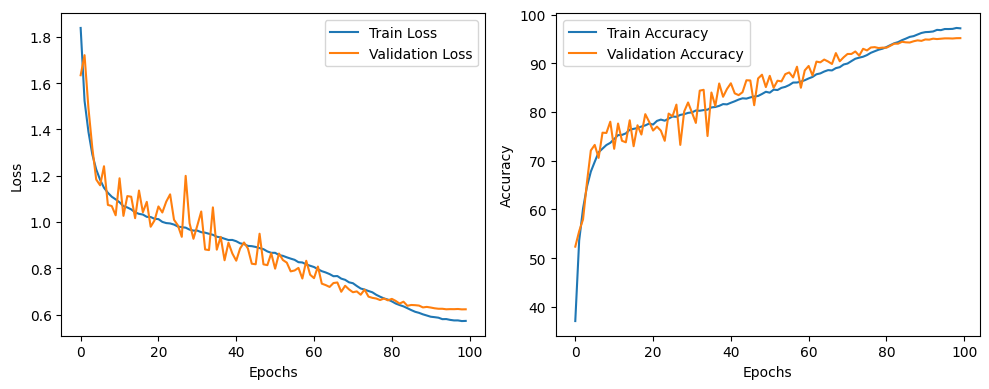

In [ ]:
fig, ax = plt.subplots(1,2,figsize=(10,4))
ax[0].plot(train_loss, label="Train Loss")
ax[0].plot(val_loss, label="Validation Loss")
ax[0].set_xlabel("Epochs")
ax[0].set_ylabel("Loss")
ax[0].legend()

ax[1].plot(train_accuracies, label="Train Accuracy")
ax[1].plot(val_accuracies, label="Validation Accuracy")
ax[1].set_xlabel("Epochs")
ax[1].set_ylabel("Accuracy")
ax[1].legend()
plt.tight_layout()

In [ ]:
torch.save(model.state_dict(), './ResNet4_4_3.pth')

<ipython-input-129-d501dd5d0cd0>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model = torch.load('./ResNet4_4_3.pth')


In [ ]:
def unpickle(file):
    import pickle
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

In [ ]:
pred_batch = unpickle('cifar_test_nolabel.pkl')
pred_images = pred_batch[b'data']
pred_dataset = [test_transform(img) for img in pred_images]
pred_loader =  torch.utils.data.DataLoader(pred_dataset, batch_size=128, shuffle = False)
model.eval()
predictions_made = []
with torch.no_grad():
  for images in pred_loader:
    images = images.to(device)
    pred = model(images)
    _, predicted = torch.max(pred, 1)
    predictions_made.extend(predicted.cpu().numpy())
benchmark = pd.DataFrame({'ID': [i for i in range(len(predictions_made))], 'Labels': predictions_made})
benchmark.to_csv('./benchmark.csv', index=False)